In [114]:
import altair as alt
from bs4 import BeautifulSoup
from vega_datasets import data
import geopandas
import json
import shapely
import re
%matplotlib inline

# Extract locations from XML data

In [3]:
portraitRaw = open('../portrait.xml').read()
portraitSoup = BeautifulSoup(portraitRaw)
geos = portraitSoup.find_all('geo')

In [12]:
points = [shapely.geometry.point.Point([float(x) for x in pt.strip().split()]) for pt in geotext]

In [8]:
geotext = [item.text for item in geos]

In [26]:
lineNos = [int(item.parent.parent.find_previous('lb').attrs['n']) for item in geos]

In [48]:
def clean(text): 
    return re.sub('\s+', ' ', text.strip().replace('\n', ' '))

In [50]:
names = [clean(item.parent.parent.find('placename').text.strip()) for item in geos]

In [52]:
gdf = geopandas.GeoDataFrame({'name': names, 'lineNo': lineNos, 'geometry': points})

In [118]:
gdf.head()

,name,lineNo,geometry
0,Leicester Abbey,10112,POINT (52.640379 -1.132563)
1,Leicester Abbey,10116,POINT (52.640379 -1.132563)
2,Mozambique Channel,10132,POINT (-18.615949 41.280858)
3,the longest river in America,10133,POINT (38.627003 -90.199404)
4,Wicklow Hotel,10154,POINT (53.342872 -6.260651)


# Use Natural Earth Land Vectors

From: https://www.naturalearthdata.com/downloads/50m-physical-vectors/50m-land/

In [161]:
gdf2 = geopandas.read_file('ne_50m_land.shp')

In [121]:
base = gdf2.cx[-8:-4,52:53]

In [122]:
base

,scalerank,featurecla,min_zoom,geometry
135,0,Land,0.0,"POLYGON ((-3.109667968749989 58.515478515625, ..."
136,0,Land,0.0,"POLYGON ((-7.178613281249994 55.056884765625, ..."


Set CRS, whatever that is.

In [126]:
base.crs

{'init': 'epsg:4326'}

In [135]:
gdf.crs = gdf2.crs

In [147]:
gdf.crs, base.crs, gdf2.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'}, {'init': 'epsg:4326'})

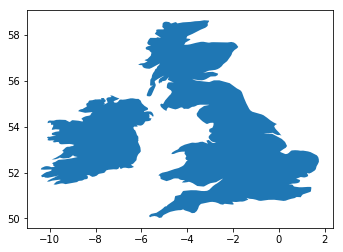

In [148]:
ax = base.plot()

In [158]:
gdf.plot(ax=ax, marker='o', color='white', markersize=5)

<Figure size 432x288 with 0 Axes>